# Computer Vision CSCI-GA.2272-001 Assignment 1

## Alex Sung-Min Hong

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to NYU classes.

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [14]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0) 
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Warm up

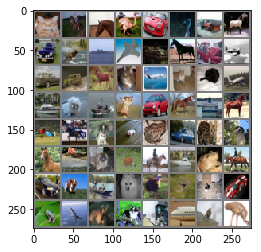

In [42]:
# code inspired from pytorch tutorial
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


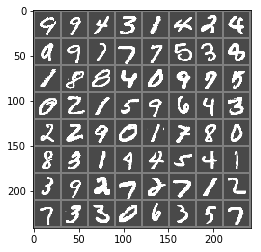

In [45]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Training a Single Layer Network

(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report.

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the train function]. Paste the output into your report and explain what is happening to the model.

In [9]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [5]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = Variable(data, volatile=True), Variable(target)
            data, target = Variable(data), Variable(target)
            output = network(data)            
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331326
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.710027
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.449518
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.299408
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.534966
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.342003
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.348947
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.273366
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.198136
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.264808

Test set: Average loss: 0.3321, Accuracy: 9079/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.320467
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.340967
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.182741
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.372572
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.303660
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.425485
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.256288
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.372418
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.291230
T

### Visualizing the weight

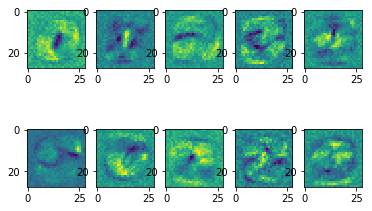

In [8]:
plt_pos = 1
for tensor in list(network.parameters())[0]:
    tmp = tensor.detach().numpy().reshape((28,28))
    plt.subplot(2,5,plt_pos)
    plt.imshow(tmp)
    plt_pos +=1
    #plt.imshow(tmp)

### Limit the training example to 50
As original batch size was given as 64, I reduced it to 50 and limit the iteration to 1.

In [11]:
# extract 50 images and target
dataiter = iter(train_loader)
images, labels = dataiter.next()
data_50, target_50 = images[:50], labels[:50]

In [7]:
data_50.shape, target_50.shape

(torch.Size([50, 1, 28, 28]), torch.Size([50]))

In [18]:
def train_50(epoch, data, target):
    network.train()
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = network(data)            
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [19]:
for epoch in range(1, epochs + 1):
    train_50(epoch, data_50, target_50)
    test()

Train Epoch: 1 	Loss: 1.984995

Test set: Average loss: 2.2056, Accuracy: 2224/10000 (22%)

Train Epoch: 2 	Loss: 1.821846

Test set: Average loss: 2.1361, Accuracy: 2752/10000 (27%)

Train Epoch: 3 	Loss: 1.680740

Test set: Average loss: 2.0721, Accuracy: 3184/10000 (31%)

Train Epoch: 4 	Loss: 1.557027

Test set: Average loss: 2.0131, Accuracy: 3561/10000 (35%)

Train Epoch: 5 	Loss: 1.447482

Test set: Average loss: 1.9590, Accuracy: 3890/10000 (38%)

Train Epoch: 6 	Loss: 1.349789

Test set: Average loss: 1.9093, Accuracy: 4164/10000 (41%)

Train Epoch: 7 	Loss: 1.262201

Test set: Average loss: 1.8638, Accuracy: 4408/10000 (44%)

Train Epoch: 8 	Loss: 1.183340

Test set: Average loss: 1.8223, Accuracy: 4642/10000 (46%)

Train Epoch: 9 	Loss: 1.112080

Test set: Average loss: 1.7843, Accuracy: 4836/10000 (48%)

Train Epoch: 10 	Loss: 1.047486

Test set: Average loss: 1.7496, Accuracy: 4974/10000 (49%)



In [20]:
# additional training to see if more iteration can result in better result
for epoch in range(1, 21):
    train_50(epoch, data_50, target_50)
    test()

Train Epoch: 1 	Loss: 0.988765

Test set: Average loss: 1.7179, Accuracy: 5116/10000 (51%)

Train Epoch: 2 	Loss: 0.935241

Test set: Average loss: 1.6889, Accuracy: 5235/10000 (52%)

Train Epoch: 3 	Loss: 0.886328

Test set: Average loss: 1.6623, Accuracy: 5317/10000 (53%)

Train Epoch: 4 	Loss: 0.841521

Test set: Average loss: 1.6379, Accuracy: 5412/10000 (54%)

Train Epoch: 5 	Loss: 0.800375

Test set: Average loss: 1.6155, Accuracy: 5482/10000 (54%)

Train Epoch: 6 	Loss: 0.762505

Test set: Average loss: 1.5948, Accuracy: 5548/10000 (55%)

Train Epoch: 7 	Loss: 0.727568

Test set: Average loss: 1.5757, Accuracy: 5611/10000 (56%)

Train Epoch: 8 	Loss: 0.695265

Test set: Average loss: 1.5581, Accuracy: 5664/10000 (56%)

Train Epoch: 9 	Loss: 0.665331

Test set: Average loss: 1.5417, Accuracy: 5700/10000 (57%)

Train Epoch: 10 	Loss: 0.637531

Test set: Average loss: 1.5265, Accuracy: 5741/10000 (57%)

Train Epoch: 11 	Loss: 0.611660

Test set: Average loss: 1.5123, Accuracy: 5766

Unlike utilizing all of the image set, just using 50 images (and reusing them over all epoches) makes the training slower and could not be trained properly. Even I trained 20 more epoches, the accuracy could not go as high as the previous model. Presumably this is because the model could not see wider variance (more instances of different style of handwriting in this dataset).

### Mulit-layer Network

In [4]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
H = 1000

class Net(nn.Module):
    def __init__(self, num_inputs, H, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, H)
        self.linear2 = nn.Linear(H, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = F.tanh(self.linear(input)) #tanh non-linearity is applied
        output = self.linear2(x)
        return output

network = Net(num_inputs, H, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

/Users/alex/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303392
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.683273
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.479705
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.443493
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.342164
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.471349
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.353442
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.416555
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.569542
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.384734

Test set: Average loss: 0.3234, Accuracy: 9103/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.393145
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.397574
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.238695
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.247552
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.176166
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.334397
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.197348
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.260799
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.246947
T

#### Set the learning rate to 10

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

/Users/alex/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.384312
Train Epoch: 1 [6400/60000 (11%)]	Loss: 857.782776
Train Epoch: 1 [12800/60000 (21%)]	Loss: 318.711609
Train Epoch: 1 [19200/60000 (32%)]	Loss: 532.822388
Train Epoch: 1 [25600/60000 (43%)]	Loss: 151.220749
Train Epoch: 1 [32000/60000 (53%)]	Loss: 368.182404
Train Epoch: 1 [38400/60000 (64%)]	Loss: 245.531525
Train Epoch: 1 [44800/60000 (75%)]	Loss: 396.018707
Train Epoch: 1 [51200/60000 (85%)]	Loss: 235.308777
Train Epoch: 1 [57600/60000 (96%)]	Loss: 345.961334

Test set: Average loss: 245.7497, Accuracy: 5547/10000 (55%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 260.647003
Train Epoch: 2 [6400/60000 (11%)]	Loss: 169.057205
Train Epoch: 2 [12800/60000 (21%)]	Loss: 214.247757
Train Epoch: 2 [19200/60000 (32%)]	Loss: 449.841919
Train Epoch: 2 [25600/60000 (43%)]	Loss: 582.199280
Train Epoch: 2 [32000/60000 (53%)]	Loss: 130.381165
Train Epoch: 2 [38400/60000 (64%)]	Loss: 189.645493
Train Epoch: 2 [44800/60000 (75%)]	Loss: 421.038208
Train Epoch: 2 

The loss value fluctuates and does not reach to the point as previously reached: loss figures are way higher than previous experiment. Too high of a learning rate cause drastic updates and it jumps over the ideal minima and it results in a continued noisy convergence in the general region of the minima.

### CIFAR 10

In [4]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
H = 1000

class Net(nn.Module):
    def __init__(self, num_inputs, H, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16 , 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.fc1 = nn.Linear(128*5*5, 64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, input):
        #input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = F.max_pool2d(torch.tanh(self.conv1(input)), (2,2))
        x = F.max_pool2d(torch.tanh(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = torch.tanh(self.fc1(x))
        output = self.fc2(x)
        
        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
network = Net(num_inputs, H, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [5]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            #data, target = Variable(data, volatile=True), Variable(target)
            data, target = Variable(data), Variable(target)
            output = network(data)            
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301779
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.208291
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.034772
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.043201
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.013109
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.841955
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.794079
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.042363

Test set: Average loss: 1.7985, Accuracy: 3771/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.833591
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.735649
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.647879
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.688655
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.766488
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.424248
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.680167
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.804796

Test set: Average loss: 1.6084, Accuracy: 4303/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.348223
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.596


Test set: Average loss: 0.9537, Accuracy: 6660/10000 (66%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.693190
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.698317
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.857866
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.767371
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.911817
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.719262
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.764913
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.832705

Test set: Average loss: 0.9864, Accuracy: 6491/10000 (64%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.760706
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.888885
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.800858
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.722524
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.757686
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.886096
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.930425
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.776070

Test set: Average loss: 0.9332, Accuracy: 6759/10000 (67%)



### Visualizing First Layer Filter

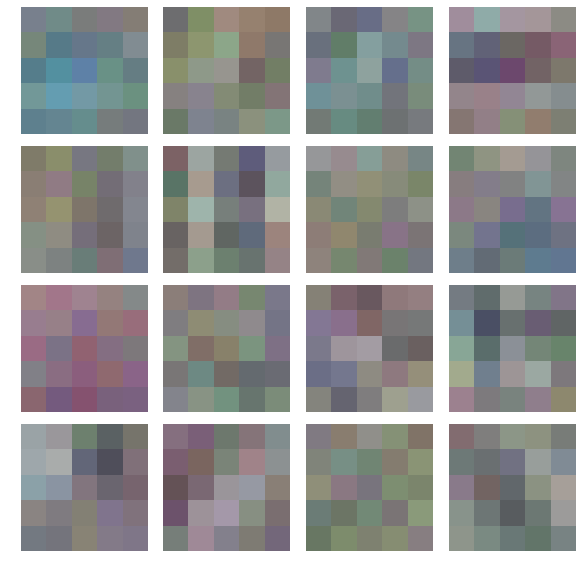

In [33]:
if dataset == 'cifar10':
    kernels = network.conv1.weight.detach().numpy()
    
    fig = plt.figure(figsize=(10,10))
    
    for i, kernel in enumerate(kernels):
        kernel = kernel /2 + 0.5
        kernel = kernel.reshape((3, 5, 5))
        kernel = np.moveaxis(kernel, 0, 2)
        
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(kernel)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [8]:
total = 0
for name, param in network.named_parameters():
    param_val = np.prod(list(param.size()))
    print("{} = {}".format(name, param_val))
    
    total += param_val

print ("Total parameters : {}".format(total))

conv1.weight = 1200
conv1.bias = 16
conv2.weight = 51200
conv2.bias = 128
fc1.weight = 204800
fc1.bias = 64
fc2.weight = 640
fc2.bias = 10
Total parameters : 258058
